In [34]:
import pandas as pd
inventory = pd.read_csv('T_F41SCHEDULE_B43.zip')

<ipython-input-34-f9c14b8dfe96>:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  inventory = pd.read_csv('T_F41SCHEDULE_B43.zip')


In [35]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132264 non-null  object 
 2   CARRIER_NAME         132208 non-null  object 
 3   MANUFACTURE_YEAR     132310 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132212 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

In [36]:
naa_mask = (
    inventory['CARRIER'].isna() &
    inventory['CARRIER_NAME'].str.upper().eq('NORTH AMERICAN AIRLINES')
)

inventory.loc[naa_mask, 'CARRIER'] = 'NA'
if 'UNIQUE_CARRIER' in inventory.columns:
    inventory.loc[naa_mask, 'UNIQUE_CARRIER'] = 'NA'


cols_of_interest = [
    'CARRIER',
    'CARRIER_NAME',
    'MANUFACTURE_YEAR',
    'NUMBER_OF_SEATS',
    'CAPACITY_IN_POUNDS',
    'AIRLINE_ID'
]

missing_summary = inventory[cols_of_interest].isna().sum()
print("Missing values for each column of interest:\n", missing_summary)


missing_percentage = (
    inventory[cols_of_interest].isna().mean() * 100
).round(2)
print("\nPercentage of missing values:\n", missing_percentage)


Missing values for each column of interest:
 CARRIER                 0
CARRIER_NAME          105
MANUFACTURE_YEAR        3
NUMBER_OF_SEATS         7
CAPACITY_IN_POUNDS    101
AIRLINE_ID            105
dtype: int64

Percentage of missing values:
 CARRIER               0.00
CARRIER_NAME          0.08
MANUFACTURE_YEAR      0.00
NUMBER_OF_SEATS       0.01
CAPACITY_IN_POUNDS    0.08
AIRLINE_ID            0.08
dtype: float64


In [37]:
carrier_counts_by_id = (
    inventory.groupby('AIRLINE_ID')['CARRIER']
    .nunique(dropna=True)
    .reset_index(name='unique_carrier_count')
)

print("Unique Carrier Count by Airline ID (first 10 rows):")
print(carrier_counts_by_id.head(10))


Unique Carrier Count by Airline ID (first 10 rows):
   AIRLINE_ID  unique_carrier_count
0     19386.0                     2
1     19393.0                     2
2     19678.0                     2
3     19687.0                     2
4     19690.0                     2
5     19704.0                     2
6     19790.0                     2
7     19805.0                     2
8     19874.0                     2
9     19917.0                     2


In [38]:
naa_mask = inventory['CARRIER_NAME'].str.upper().eq('NORTH AMERICAN AIRLINES')
print(f"\nRows with 'North American Airlines': {naa_mask.sum()}")

print(inventory.loc[naa_mask, ['CARRIER_NAME', 'CARRIER', 'AIRLINE_ID']].head(10))



Rows with 'North American Airlines': 59
                  CARRIER_NAME CARRIER  AIRLINE_ID
11776  North American Airlines      NA     20415.0
11777  North American Airlines      NA     20415.0
11778  North American Airlines      NA     20415.0
11779  North American Airlines      NA     20415.0
11780  North American Airlines      NA     20415.0
11781  North American Airlines      NA     20415.0
11782  North American Airlines      NA     20415.0
11783  North American Airlines      NA     20415.0
11784  North American Airlines      NA     20415.0
11785  North American Airlines      NA     20415.0


In [39]:
carrier_map = (
    inventory.dropna(subset=['CARRIER'])
    .groupby('AIRLINE_ID')['CARRIER']
    .agg(['nunique', 'first'])
    .query('nunique == 1')
    ['first']
    .to_dict()
)

print("Carrier map (AIRLINE_ID -> single known CARRIER) count:", len(carrier_map))


Carrier map (AIRLINE_ID -> single known CARRIER) count: 48


In [40]:
inventory['CARRIER_imputed'] = inventory['CARRIER'].copy()

mask_missing_carrier = inventory['CARRIER_imputed'].isna()
inventory.loc[mask_missing_carrier, 'CARRIER_imputed'] = \
    inventory.loc[mask_missing_carrier, 'AIRLINE_ID'].map(carrier_map)

still_missing_carrier = inventory['CARRIER_imputed'].isna().sum()
print("Remaining missing in 'CARRIER_imputed':", still_missing_carrier)


Remaining missing in 'CARRIER_imputed': 0


In [41]:
name_map = (
    inventory.dropna(subset=['CARRIER_NAME'])
    .groupby('AIRLINE_ID')['CARRIER_NAME']
    .agg(['nunique', 'first'])
    .query('nunique == 1')
    ['first']
    .to_dict()
)

inventory['CARRIER_NAME_imputed'] = inventory['CARRIER_NAME'].copy()

mask_missing_name = inventory['CARRIER_NAME_imputed'].isna()
inventory.loc[mask_missing_name, 'CARRIER_NAME_imputed'] = \
    inventory.loc[mask_missing_name, 'AIRLINE_ID'].map(name_map)

still_missing_name = inventory['CARRIER_NAME_imputed'].isna().sum()
print("Remaining missing in 'CARRIER_NAME_imputed':", still_missing_name)


Remaining missing in 'CARRIER_NAME_imputed': 105


In [42]:
num_cols = ['MANUFACTURE_YEAR', 'NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS']

print("Summary stats before any numeric imputation:")
print(inventory[num_cols].describe())


Summary stats before any numeric imputation:
       MANUFACTURE_YEAR  NUMBER_OF_SEATS  CAPACITY_IN_POUNDS
count     132310.000000    132306.000000       132212.000000
mean        2000.399992       110.619859        71313.508131
std           39.630346        77.424860        87093.991985
min            0.000000         0.000000            0.000000
25%         1995.000000        50.000000        34446.000000
50%         2001.000000       125.000000        43400.000000
75%         2007.000000       160.000000        82012.000000
max         2756.000000       737.000000       875000.000000


In [43]:
inventory['MANUFACTURE_YEAR_imputed'] = \
    inventory['MANUFACTURE_YEAR'].fillna(inventory['MANUFACTURE_YEAR'].median())

inventory['NUMBER_OF_SEATS_imputed'] = \
    inventory['NUMBER_OF_SEATS'].fillna(inventory['NUMBER_OF_SEATS'].median())

inventory['CAPACITY_IN_POUNDS_imputed'] = \
    inventory['CAPACITY_IN_POUNDS'].fillna(inventory['CAPACITY_IN_POUNDS'].median())

print("\nMissing after median imputation:")
print(inventory[[
    'MANUFACTURE_YEAR_imputed',
    'NUMBER_OF_SEATS_imputed',
    'CAPACITY_IN_POUNDS_imputed'
]].isna().sum())



Missing after median imputation:
MANUFACTURE_YEAR_imputed      0
NUMBER_OF_SEATS_imputed       0
CAPACITY_IN_POUNDS_imputed    0
dtype: int64


In [44]:
print("\n----- Final Check of Missingness -----")
post_impute_cols = [
    'CARRIER_imputed',
    'CARRIER_NAME_imputed',
    'MANUFACTURE_YEAR_imputed',
    'NUMBER_OF_SEATS_imputed',
    'CAPACITY_IN_POUNDS_imputed',
    'AIRLINE_ID'
]
print(inventory[post_impute_cols].isna().sum())



----- Final Check of Missingness -----
CARRIER_imputed                 0
CARRIER_NAME_imputed          105
MANUFACTURE_YEAR_imputed        0
NUMBER_OF_SEATS_imputed         0
CAPACITY_IN_POUNDS_imputed      0
AIRLINE_ID                    105
dtype: int64


In [45]:
text_cols = ['MANUFACTURER', 'MODEL', 'AIRCRAFT_STATUS', 'OPERATING_STATUS']

inventory[text_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   MANUFACTURER      132313 non-null  object
 1   MODEL             132302 non-null  object
 2   AIRCRAFT_STATUS   132313 non-null  object
 3   OPERATING_STATUS  132313 non-null  object
dtypes: object(4)
memory usage: 4.0+ MB


In [46]:
for col in text_cols:
    print(f"\n== {col} value counts ==")
    print(inventory[col].value_counts(dropna=False).head(10))



== MANUFACTURER value counts ==
MANUFACTURER
BOEING              15922
Embraer             11508
THEBOEINGCO          9223
Bombardier           8871
Boeing               8392
BoeingCo             7446
AIRBUS               7179
AirbusIndustries     6967
BOEINGCOMPANY        6767
Airbus               5289
Name: count, dtype: int64

== MODEL value counts ==
MODEL
EMB-145                 2614
B-737-7H4               2470
B737-823                2370
A320-232                2333
A321-231                2259
737-700PASSENGERONLY    2027
C-208B                  1872
B757-2                  1775
CRJ-2/4                 1761
B737-800PAX             1621
Name: count, dtype: int64

== AIRCRAFT_STATUS value counts ==
AIRCRAFT_STATUS
O    79487
b    30852
B    12699
a     7804
A     1330
L      122
o       19
Name: count, dtype: int64

== OPERATING_STATUS value counts ==
OPERATING_STATUS
Y    126577
N      5664
y        71
          1
Name: count, dtype: int64


In [47]:
inventory['MANUFACTURER_std'] = (
    inventory['MANUFACTURER']
    .astype(str)
    .str.strip()
    .str.upper()
)

inventory['MODEL_std'] = (
    inventory['MODEL']
    .astype(str)
    .str.strip()
    .str.upper()
)

inventory['AIRCRAFT_STATUS_std'] = (
    inventory['AIRCRAFT_STATUS']
    .astype(str)
    .str.strip()
    .str.upper()
)

inventory['OPERATING_STATUS_std'] = (
    inventory['OPERATING_STATUS']
    .astype(str)
    .str.strip()
    .str.upper()
)


In [48]:
manufacturer_counts = inventory['MANUFACTURER_std'].value_counts().head(10)
print(manufacturer_counts)


MANUFACTURER_std
BOEING              27159
EMBRAER             15554
AIRBUS              13440
BOMBARDIER          11834
THEBOEINGCO          9231
BOEINGCO             7801
AIRBUSINDUSTRIES     7053
BOEINGCOMPANY        6767
CESSNA               4514
MCDONNELLDOUGLAS     4306
Name: count, dtype: int64


In [49]:
manufacturer_expanded_replacements = {
    "THEBOEINGCO": "BOEING",
    "THEBOEINGCOMPANY": "BOEING",
    "BOEINGCO": "BOEING",
    "BOEINGCO.": "BOEING",
    "BOEINGCOMPANY": "BOEING",
    "BOEING(MCDONNELL-DOUGLAS)": "BOEING",

    "AIRBUSINDUSTRIES": "AIRBUS",
    "AIRBUSINDUSTRIE": "AIRBUS",
    "AIRBUSCOMPANY": "AIRBUS",

    "BOMBARDIERAEROSPACE": "BOMBARDIER",
    "CANADAIR": "BOMBARDIER",


    "MCDONNELLDOUGLAS": "BOEING",
    "MCDONNELLDOUGLASMD11-F": "BOEING",
    "MDDOUGLAS": "BOEING",
    "MCDONALDDOUGLAS": "BOEING",
    "MCDONNELL-DOUGLAS": "BOEING",
    "MCDO": "BOEING",
    "DOUGLAS": "BOEING",
    "DOUGLASAIRCRAFT": "BOEING",
    "MCDONNELDOUGLAS": "BOEING",

    "DEHAVILLAND": "DE HAVILLAND",

    "DASSULT SUD": "DASSAULT",
    "DASSAULT/SUD": "DASSAULT",

    "SAAB AIRCRAFT": "SAAB",


    "EASYJET/GOAL": "LEASE/OPERATOR",
    "EASYJET/GECAS": "LEASE/OPERATOR",
    "IBERIA/SMBC": "LEASE/OPERATOR",
    "VUELING/AERCAP": "LEASE/OPERATOR",
    "SAUDIA/ALAFCO": "LEASE/OPERATOR",
    "ALITALIA/REALIS": "LEASE/OPERATOR",
    "ALC/ALASKA": "LEASE/OPERATOR",
    "SMBCAVIATIONCAPITALLIMITED": "LEASE/OPERATOR",
    "VUELING/GECAS": "LEASE/OPERATOR",
    "CEBUPACIFIC": "LEASE/OPERATOR",
    "CEBUPACIFIC/SMBC": "LEASE/OPERATOR",
    "IBERIA/ILFC": "LEASE/OPERATOR",
    "AERCAP": "LEASE/OPERATOR",
    "COBALT/ICBC": "LEASE/OPERATOR",
    "AVIANCA/ACG": "LEASE/OPERATOR",


    "CHALLENGER300": "BOMBARDIER",
    "DORNIER": "DORNIER",
    "CURTISS": "CURTISS",
    "FAIRCHILD": "FAIRCHILD",
    "CONVAIR": "CONVAIR",
    "HAWKER": "HAWKER",
    "PIPER": "PIPER",
    "PILATUS": "PILATUS",
    "PIPISTRELDOO": "PIPISTREL",
    "BAE": "BAE",
    "DASSAULT": "DASSAULT",
    "FOKKER": "FOKKER",
    "LOCKHEED": "LOCKHEED",
    "GE": "GENERAL ELECTRIC",
    "CFMINTERNATIONAL": "CFM INTERNATIONAL",
}

inventory['MANUFACTURER_cleaned_v2'] = (
    inventory['MANUFACTURER_std']
    .replace(manufacturer_expanded_replacements)
)

print("\nAfter the expanded replacement dictionary, top 10 values:")
print(inventory['MANUFACTURER_cleaned_v2'].value_counts().head(10))



After the expanded replacement dictionary, top 10 values:
MANUFACTURER_cleaned_v2
BOEING              66445
AIRBUS              23513
BOMBARDIER          16371
EMBRAER             15554
CESSNA               4514
ATR                  1181
GENERAL ELECTRIC     1110
DE HAVILLAND         1084
SAAB                  595
GULFSTREAM            441
Name: count, dtype: int64


In [50]:
print(inventory['MODEL_std'].value_counts().head(10))

MODEL_std
EMB-145                 2976
B-737-7H4               2470
B737-823                2370
A320-232                2333
A321-231                2259
737-700PASSENGERONLY    2027
C-208B                  1872
B757-2                  1775
CRJ-2/4                 1761
B737-800PAX             1621
Name: count, dtype: int64


In [51]:
import re

def remove_keywords(model_str):
    s = model_str.upper().strip()

    s = re.sub(r'PASSENGER', '', s)
    s = re.sub(r'PSGR', '', s)
    s = re.sub(r'ONLY', '', s)
    s = re.sub(r'PAX', '', s)
    s = re.sub(r'AIRBUS', '', s)
    s = re.sub(r'ALL', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s


inventory['MODEL_cleaned'] = inventory['MODEL'].astype(str).apply(remove_keywords)

print(inventory['MODEL_cleaned'].value_counts().head(10))


MODEL_cleaned
A320-232     3505
B737-823     3326
EMB-145      2976
B-737-7H4    2470
A321-231     2294
737-700      2042
B737-800     1874
C-208B       1872
B757-2       1775
CRJ-2/4      1761
Name: count, dtype: int64


In [52]:
print(inventory['AIRCRAFT_STATUS_std'].value_counts().head(10))

AIRCRAFT_STATUS_std
O    79506
B    43551
A     9134
L      122
Name: count, dtype: int64


In [53]:
print(inventory['OPERATING_STATUS_std'].value_counts().head(10))

OPERATING_STATUS_std
Y    126648
N      5664
          1
Name: count, dtype: int64


In [54]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   YEAR                        132313 non-null  int64  
 1   CARRIER                     132313 non-null  object 
 2   CARRIER_NAME                132208 non-null  object 
 3   MANUFACTURE_YEAR            132310 non-null  float64
 4   UNIQUE_CARRIER_NAME         132208 non-null  object 
 5   SERIAL_NUMBER               132313 non-null  object 
 6   TAIL_NUMBER                 132313 non-null  object 
 7   AIRCRAFT_STATUS             132313 non-null  object 
 8   OPERATING_STATUS            132313 non-null  object 
 9   NUMBER_OF_SEATS             132306 non-null  float64
 10  MANUFACTURER                132313 non-null  object 
 11  AIRCRAFT_TYPE               102380 non-null  object 
 12  MODEL                       132302 non-null  object 
 13  CAPACITY_IN_PO

In [55]:
inventory_final = inventory.copy()

inventory_final['CARRIER']            = inventory['CARRIER_imputed']
inventory_final['CARRIER_NAME']       = inventory['CARRIER_NAME_imputed']
inventory_final['MANUFACTURE_YEAR']   = inventory['MANUFACTURE_YEAR_imputed']
inventory_final['NUMBER_OF_SEATS']    = inventory['NUMBER_OF_SEATS_imputed']
inventory_final['CAPACITY_IN_POUNDS'] = inventory['CAPACITY_IN_POUNDS_imputed']

inventory_final['MANUFACTURER']       = inventory['MANUFACTURER_cleaned_v2']
inventory_final['MODEL']             = inventory['MODEL_cleaned']
inventory_final['AIRCRAFT_STATUS']    = inventory['AIRCRAFT_STATUS_std']
inventory_final['OPERATING_STATUS']   = inventory['OPERATING_STATUS_std']

final_cols = [
    'YEAR', 'CARRIER', 'CARRIER_NAME', 'MANUFACTURE_YEAR',
    'UNIQUE_CARRIER_NAME', 'SERIAL_NUMBER', 'TAIL_NUMBER',
    'AIRCRAFT_STATUS', 'OPERATING_STATUS', 'NUMBER_OF_SEATS',
    'MANUFACTURER', 'AIRCRAFT_TYPE', 'MODEL', 'CAPACITY_IN_POUNDS',
    'ACQUISITION_DATE', 'AIRLINE_ID', 'UNIQUE_CARRIER'
]
inventory_final = inventory_final[final_cols]

inventory_final.dropna(inplace=True)

print("Final inventory rows x columns:", inventory_final.shape)



Final inventory rows x columns: (101316, 17)


In [56]:
inventory_final.info()


<class 'pandas.core.frame.DataFrame'>
Index: 101316 entries, 29239 to 132312
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 101316 non-null  int64  
 1   CARRIER              101316 non-null  object 
 2   CARRIER_NAME         101316 non-null  object 
 3   MANUFACTURE_YEAR     101316 non-null  float64
 4   UNIQUE_CARRIER_NAME  101316 non-null  object 
 5   SERIAL_NUMBER        101316 non-null  object 
 6   TAIL_NUMBER          101316 non-null  object 
 7   AIRCRAFT_STATUS      101316 non-null  object 
 8   OPERATING_STATUS     101316 non-null  object 
 9   NUMBER_OF_SEATS      101316 non-null  float64
 10  MANUFACTURER         101316 non-null  object 
 11  AIRCRAFT_TYPE        101316 non-null  object 
 12  MODEL                101316 non-null  object 
 13  CAPACITY_IN_POUNDS   101316 non-null  float64
 14  ACQUISITION_DATE     101316 non-null  object 
 15  AIRLINE_ID        

Skewness (before) - NUMBER_OF_SEATS: 0.38
Skewness (before) - CAPACITY_IN_POUNDS: 3.77


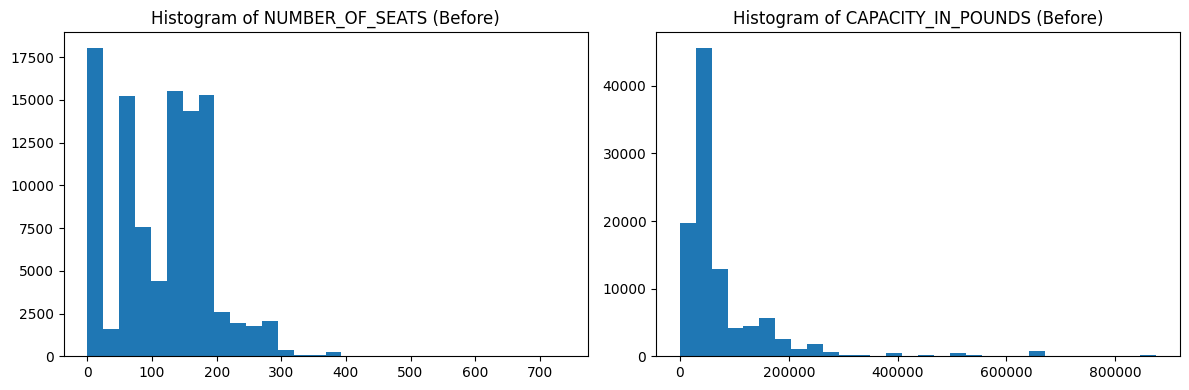

In [57]:
from matplotlib import pyplot as plt
from scipy.stats import boxcox

df = inventory_final.copy()

skew_seats_before = df['NUMBER_OF_SEATS'].skew()
skew_capacity_before = df['CAPACITY_IN_POUNDS'].skew()

print(f"Skewness (before) - NUMBER_OF_SEATS: {skew_seats_before:.2f}")
print(f"Skewness (before) - CAPACITY_IN_POUNDS: {skew_capacity_before:.2f}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].hist(df['NUMBER_OF_SEATS'], bins=30)
axes[0].set_title("Histogram of NUMBER_OF_SEATS (Before)")

axes[1].hist(df['CAPACITY_IN_POUNDS'], bins=30)
axes[1].set_title("Histogram of CAPACITY_IN_POUNDS (Before)")

plt.tight_layout()
plt.show()


Box-Cox lambda for NUMBER_OF_SEATS: 0.584
Box-Cox lambda for CAPACITY_IN_POUNDS: 0.300

Skewness (after) - NUMBER_OF_SEATS_BOXCOX: -0.53
Skewness (after) - CAPACITY_IN_POUNDS_BOXCOX: 0.19


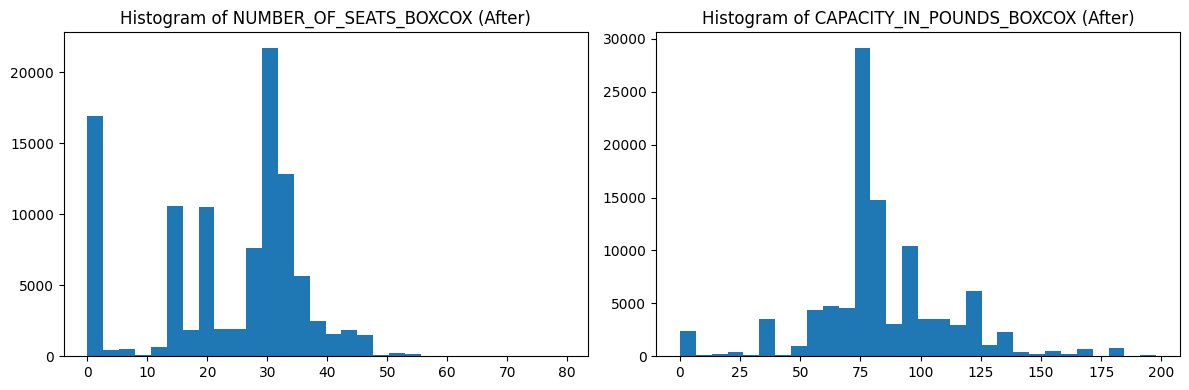

In [58]:

shift_seats = 1 - df['NUMBER_OF_SEATS'].min() if df['NUMBER_OF_SEATS'].min() <= 0 else 0
shift_capacity = 1 - df['CAPACITY_IN_POUNDS'].min() if df['CAPACITY_IN_POUNDS'].min() <= 0 else 0

df['NUMBER_OF_SEATS_SHIFTED'] = df['NUMBER_OF_SEATS'] + shift_seats
df['CAPACITY_IN_POUNDS_SHIFTED'] = df['CAPACITY_IN_POUNDS'] + shift_capacity

df['NUMBER_OF_SEATS_BOXCOX'], lambda_seats = boxcox(df['NUMBER_OF_SEATS_SHIFTED'])
df['CAPACITY_IN_POUNDS_BOXCOX'], lambda_capacity = boxcox(df['CAPACITY_IN_POUNDS_SHIFTED'])

print(f"Box-Cox lambda for NUMBER_OF_SEATS: {lambda_seats:.3f}")
print(f"Box-Cox lambda for CAPACITY_IN_POUNDS: {lambda_capacity:.3f}")


skew_seats_after = df['NUMBER_OF_SEATS_BOXCOX'].skew()
skew_capacity_after = df['CAPACITY_IN_POUNDS_BOXCOX'].skew()

print(f"\nSkewness (after) - NUMBER_OF_SEATS_BOXCOX: {skew_seats_after:.2f}")
print(f"Skewness (after) - CAPACITY_IN_POUNDS_BOXCOX: {skew_capacity_after:.2f}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].hist(df['NUMBER_OF_SEATS_BOXCOX'], bins=30)
axes[0].set_title("Histogram of NUMBER_OF_SEATS_BOXCOX (After)")

axes[1].hist(df['CAPACITY_IN_POUNDS_BOXCOX'], bins=30)
axes[1].set_title("Histogram of CAPACITY_IN_POUNDS_BOXCOX (After)")

plt.tight_layout()
plt.show()

In [59]:
'''
Before the Box-Cox transformation, NUMBER_OF_SEATS showed a mild right skew
with most values clustered between 0 and 150. Meanwhile, CAPACITY_IN_POUNDS
exhibited a much stronger right skew due to a handful of very large capacity
aircraft. In both cases, the histograms were stretched to the right, indicating
non-normal distributions.

After the Box-Cox transformation, both variables became more symmetric.
NUMBER_OF_SEATS_BOXCOX now displays a slightly left-skewed shape, but overall
is more spread out and less extreme. CAPACITY_IN_POUNDS_BOXCOX shows a drastic
reduction in skewness, with the heavy tail largely suppressed, resulting in a
distribution that is much closer to normal.
'''

'\nBefore the Box-Cox transformation, NUMBER_OF_SEATS showed a mild right skew \nwith most values clustered between 0 and 150. Meanwhile, CAPACITY_IN_POUNDS \nexhibited a much stronger right skew due to a handful of very large capacity \naircraft. In both cases, the histograms were stretched to the right, indicating \nnon-normal distributions.\n\nAfter the Box-Cox transformation, both variables became more symmetric. \nNUMBER_OF_SEATS_BOXCOX now displays a slightly left-skewed shape, but overall \nis more spread out and less extreme. CAPACITY_IN_POUNDS_BOXCOX shows a drastic \nreduction in skewness, with the heavy tail largely suppressed, resulting in a \ndistribution that is much closer to normal.\n'

In [60]:
import pandas as pd
import matplotlib.pyplot as plt


quartiles = df['NUMBER_OF_SEATS'].quantile([0.25, 0.5, 0.75])
q1 = quartiles[0.25]
q2 = quartiles[0.5]
q3 = quartiles[0.75]

def categorize_size(seats):
    if seats < q1:
        return "SMALL"
    elif seats < q2:
        return "MEDIUM"
    elif seats < q3:
        return "LARGE"
    else:
        return "XLARGE"

df['SIZE'] = df['NUMBER_OF_SEATS'].apply(categorize_size)

print(df['SIZE'].value_counts())


SIZE
MEDIUM    30902
XLARGE    25431
LARGE     25326
SMALL     19657
Name: count, dtype: int64


In [61]:
operating_tab = pd.crosstab(df['SIZE'], df['OPERATING_STATUS'])

operating_prop = operating_tab.div(operating_tab.sum(axis=1), axis=0)
print("\nProportions of OPERATING_STATUS by SIZE:")
print(operating_prop)



Proportions of OPERATING_STATUS by SIZE:
OPERATING_STATUS                   N         Y
SIZE                                          
LARGE             0.000000  0.033286  0.966714
MEDIUM            0.000032  0.052359  0.947609
SMALL             0.000000  0.031388  0.968612
XLARGE            0.000000  0.030553  0.969447


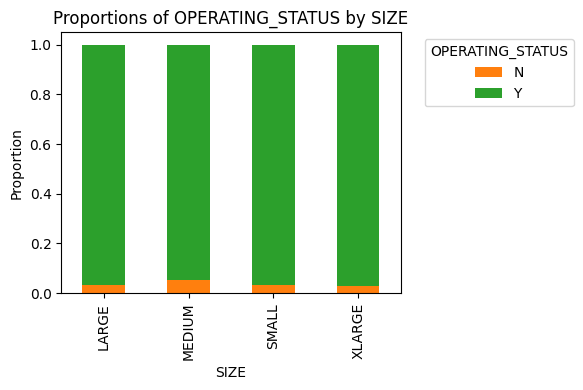

In [62]:
operating_prop.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title("Proportions of OPERATING_STATUS by SIZE")
plt.ylabel("Proportion")
plt.legend(title='OPERATING_STATUS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [63]:
status_tab = pd.crosstab(df['SIZE'], df['AIRCRAFT_STATUS'])
status_prop = status_tab.div(status_tab.sum(axis=1), axis=0)
print("\nProportions of AIRCRAFT_STATUS by SIZE:")
print(status_prop)



Proportions of AIRCRAFT_STATUS by SIZE:
AIRCRAFT_STATUS         A         B         L         O
SIZE                                                   
LARGE            0.115099  0.201098  0.001737  0.682066
MEDIUM           0.066145  0.513332  0.001100  0.419423
SMALL            0.037696  0.235234  0.000000  0.727069
XLARGE           0.076167  0.194723  0.001730  0.727380


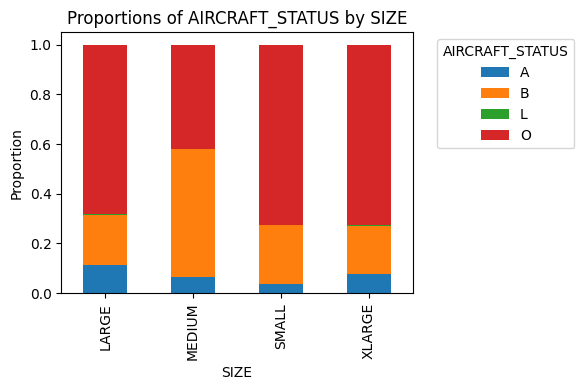

In [64]:
status_prop.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title("Proportions of AIRCRAFT_STATUS by SIZE")
plt.ylabel("Proportion")
plt.legend(title='AIRCRAFT_STATUS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [65]:
'''
Overall, aircraft in all size categories (SMALL, MEDIUM, LARGE, and XLARGE)
are predominantly in the “operating” status, with only a small fraction marked
as not operating. In other words, the proportion of OPERATING_STATUS = Y is
consistently high across the board, indicating that most aircraft—regardless
of seat capacity quartile—are active at any given time. The slight variations
among size groups suggest that while there may be occasional differences
(e.g., SMALL planes having a marginally lower operating proportion), these
differences are not dramatic.

Looking at AIRCRAFT_STATUS, the majority of aircraft in every size category
fall under status “O,” followed by status “B,” with only a small fraction in
“A” or “L.” That said, the exact mix of statuses differs slightly by size group,
as SMALL aircraft appear to have a moderately larger share of “B” (perhaps
related to storage or other categories), while LARGE and XLARGE aircraft more
often remain in “O.” This pattern highlights that bigger planes tend to stay
in a consistent operational/service status, whereas smaller planes see a bit
more variation in usage or maintenance statuses.

'''

'\nOverall, aircraft in all size categories (SMALL, MEDIUM, LARGE, and XLARGE) \nare predominantly in the “operating” status, with only a small fraction marked \nas not operating. In other words, the proportion of OPERATING_STATUS = Y is \nconsistently high across the board, indicating that most aircraft—regardless \nof seat capacity quartile—are active at any given time. The slight variations \namong size groups suggest that while there may be occasional differences \n(e.g., SMALL planes having a marginally lower operating proportion), these \ndifferences are not dramatic.\n\nLooking at AIRCRAFT_STATUS, the majority of aircraft in every size category \nfall under status “O,” followed by status “B,” with only a small fraction in \n“A” or “L.” That said, the exact mix of statuses differs slightly by size group,\nas SMALL aircraft appear to have a moderately larger share of “B” (perhaps \nrelated to storage or other categories), while LARGE and XLARGE aircraft more \noften remain in “O.”